In [5]:
dataname="synthetic"
gpuid=0

# --- densenet params
#these parameters get fed directly into the densenet class, and more description of them can be discovered there
n_classes= 2    #number of classes in the data mask that we'll aim to predict
in_channels= 3  #input channel of the data, RGB = 3


growth_rate=8 
block_config=(6, 12, 24, 16)
num_init_features=8
bn_size=4
drop_rate=0



# --- training params
batch_size=64
patch_size=224 #currently, this needs to be 224 due to densenet architecture
num_epochs = 100
phases = ["train","val"] #how many phases did we create databases for?
validation_phases= ["val"] #when should we do valiation? note that validation is *very* time consuming, so as opposed to doing for both training and validation, we do it only for vlaidation at the end of the epoch
                           #additionally, using simply [], will skip validation entirely, drastically speeding things up

In [6]:
import time
import math
import tables

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import DenseNet

from tensorboardX import SummaryWriter

In [7]:
#helper function for pretty printing of current time and remaining time
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent+.00001)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [8]:
#specify if we should use a GPU (cuda) or only the CPU
print(torch.cuda.get_device_properties(gpuid))
torch.cuda.set_device(gpuid)
device = torch.device(f'cuda:{gpuid}' if torch.cuda.is_available() else 'cpu')

_CudaDeviceProperties(name='Quadro M2200', major=5, minor=2, total_memory=4096MB, multi_processor_count=8)


In [9]:
#build the model according to the paramters specified above and copy it to the GPU. finally print out the number of trainable parameters
 
model = DenseNet(growth_rate=growth_rate, block_config=block_config,
                 num_init_features=num_init_features, bn_size=bn_size, drop_rate=drop_rate, num_classes=n_classes).to(device)

print(f"total params: \t{sum([np.prod(p.size()) for p in model.parameters()])}")

c:\python37\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


total params: 	444420


In [10]:
#this defines our dataset class which will be used by the dataloader
class Dataset(object):
    def __init__(self, fname ,img_transform=None):
        #nothing special here, just internalizing the constructor parameters
        self.fname=fname

        self.img_transform=img_transform
        
        with tables.open_file(self.fname,'r') as db:
            self.classsizes=db.root.classsizes[:]
            self.nitems=db.root.imgs.shape[0]
        
        self.imgs = None
        self.labels = None
        
    def __getitem__(self, index):
        #opening should be done in __init__ but seems to be
        #an issue with multithreading so doing here. need to do it everytime, otherwise hdf5 crashes

        with tables.open_file(self.fname,'r') as db:
            self.imgs=db.root.imgs
            self.labels=db.root.labels

            #get the requested image
            img = self.imgs[index,::]
            img = img[:,:,None].repeat(3,axis=2) #convert to 3 channel RGB
            label = self.labels[index] 
        
        img_new = img
        
        if self.img_transform is not None:
            img_new = self.img_transform(img)

        return img_new, label, img
    def __len__(self):
        return self.nitems

In [11]:
img_transform = transforms.Compose([
     transforms.ToPILImage(),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=(patch_size,patch_size),pad_if_needed=True), #these need to be in a reproducible order, first affine transforms and then color
    transforms.ToTensor()
    ])


dataset={}
dataLoader={}
for phase in phases: #now for each of the phases, we're creating the dataloader
                     #interestingly, given the batch size, i've not seen any improvements from using a num_workers>0
    
    dataset[phase]=Dataset(f"./{dataname}_{phase}.pytable", img_transform=img_transform)
    dataLoader[phase]=DataLoader(dataset[phase], batch_size=batch_size, 
                                shuffle=True, num_workers=8,pin_memory=True) 
    print(f"{phase} dataset size:\t{len(dataset[phase])}")



train dataset size:	10000
val dataset size:	100


0


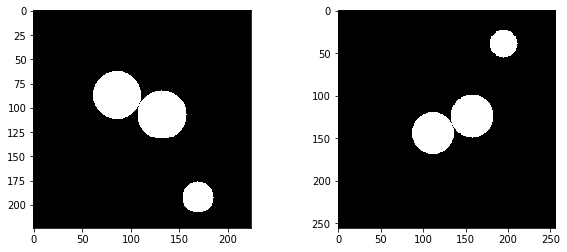

In [17]:
#visualize a single example to verify that it is correct
(img, label, img_old)=dataset["train"][24]
fig, ax = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns

#build output showing patch after augmentation and original patch
ax[0].imshow(np.moveaxis(img.numpy(),0,-1))
ax[1].imshow(img_old)

print(label)

In [ ]:
optim = torch.optim.Adam(model.parameters()) #adam is going to be the most robust, though perhaps not the best performing, typically a good place to start


In [ ]:
#we have the ability to weight individual classes, in this case we'll do so based on their presense in the trainingset
#to avoid biasing any particular class
nclasses = dataset["train"].classsizes.shape[0]
class_weight=dataset["train"].classsizes
class_weight = torch.from_numpy(1-class_weight/class_weight.sum()).type('torch.FloatTensor').to(device)

print(class_weight) #show final used weights, make sure that they're reasonable before continouing
criterion = torch.nn.CrossEntropyLoss(weight = class_weight) 


In [ ]:
#def trainnetwork():
writer=SummaryWriter() #open the tensorboard visualiser
best_loss_on_test = np.Infinity

start_time = time.time()
for epoch in range(num_epochs):
    #zero out epoch based performance variables 
    all_acc = {key: 0 for key in phases} 
    all_loss = {key: torch.zeros(0).to(device) for key in phases} #keep this on GPU for greatly improved performance
    cmatrix = {key: np.zeros((n_classes,n_classes)) for key in phases}

    for phase in phases: #iterate through both training and validation states

        if phase == 'train':
            model.train()  # Set model to training mode
        else: #when in eval mode, we don't want parameters to be updated
            model.eval()   # Set model to evaluate mode

        for ii , (X, label, img_orig) in enumerate(dataLoader[phase]): #for each of the batches
            X = X.to(device)  # [Nbatch, 3, H, W]
            label = label.type('torch.LongTensor').to(device)  # [Nbatch, 1] with class indices (0, 1, 2,...n_classes)

            with torch.set_grad_enabled(phase == 'train'): #dynamically set gradient computation, in case of validation, this isn't needed
                                                            #disabling is good practice and improves inference time

                prediction = model(X)  # [Nbatch, Nclass]
                loss = criterion(prediction, label)


                if phase=="train": #in case we're in train mode, need to do back propogation
                    optim.zero_grad()
                    loss.backward()
                    optim.step()
                    train_loss = loss


                all_loss[phase]=torch.cat((all_loss[phase],loss.detach().view(1,-1)))

                if phase in validation_phases: #if this phase is part of validation, compute confusion matrix
                    p=prediction.detach().cpu().numpy()
                    cpredflat=np.argmax(p,axis=1).flatten()
                    yflat=label.cpu().numpy().flatten()

                    cmatrix[phase]=cmatrix[phase]+confusion_matrix(yflat,cpredflat, labels=range(nclasses))

        all_acc[phase]=(cmatrix[phase]/cmatrix[phase].sum()).trace()
        all_loss[phase] = all_loss[phase].cpu().numpy().mean()

        #save metrics to tensorboard
        writer.add_scalar(f'{phase}/loss', all_loss[phase], epoch)
        if phase in validation_phases:
            writer.add_scalar(f'{phase}/acc', all_acc[phase], epoch)
            for r in range(nclasses):
                for c in range(nclasses): #essentially write out confusion matrix
                    writer.add_scalar(f'{phase}/{r}{c}', cmatrix[phase][r][c],epoch)

    print('%s ([%d/%d] %d%%), train loss: %.4f test loss: %.4f' % (timeSince(start_time, (epoch+1) / num_epochs), 
                                                 epoch+1, num_epochs ,(epoch+1) / num_epochs * 100, all_loss["train"], all_loss["val"]),end="")    

    #if current loss is the best we've seen, save model state with all variables
    #necessary for recreation
    if all_loss["val"] < best_loss_on_test:
        best_loss_on_test = all_loss["val"]
        print("  **")
        state = {'epoch': epoch + 1,
         'model_dict': model.state_dict(),
         'optim_dict': optim.state_dict(),
         'best_loss_on_test': all_loss,
         'n_classes': n_classes,
         'in_channels': in_channels,
         'growth_rate':growth_rate,
         'block_config':block_config,
         'num_init_features':num_init_features,
         'bn_size':bn_size,
         'drop_rate':drop_rate}


        torch.save(state, f"{dataname}_densenet_best_model.pth")
    else:
        print("")


In [ ]:
# %load_ext line_profiler
# %lprun -f trainnetwork trainnetwork()